# Step 1: Data Preparation


In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import emoji
import json
import re
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ryanlahlou/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load data
data = requests.get("https://smare.lryanle.com/api/ext/listings")

if data.status_code == 200:
    data = data.json()

    if data["success"]:
        flagged_listings = pd.DataFrame(data["data"]["flagged"])
        not_flagged_listings = pd.DataFrame(data["data"]["notflagged"])

        flagged_listings["flagged"] = True
        not_flagged_listings["flagged"] = False

        data = pd.concat([flagged_listings, not_flagged_listings], ignore_index=True)

        print("Data retrieved and parsed successfully!")
        print(f"Number of flagged listings: {len(flagged_listings)}")
        print(f"Number of not flagged listings: {len(not_flagged_listings)}")
    else:
        print("API returned an unsuccessful status.")
else:
    print("Failed to retrieve data. Status code:", data.status_code)

Data retrieved and parsed successfully!
Number of flagged listings: 365
Number of not flagged listings: 697


In [3]:
with open("l_kbb_prices.json", "r") as kbb_file:
    kbb_prices = json.load(kbb_file)

In [4]:
def get_listed_price(listing):
    makemodel = f"{listing['make']} {listing['model']} {listing['year']}".lower()
    fallback_makemodel = (
        f"{listing['make']} {listing['model'].split(' ')[0]} {listing['year']}".lower()
    )

    if makemodel in kbb_prices:
        return listing["price"] - int(kbb_prices[makemodel])
    elif fallback_makemodel in kbb_prices:
        return listing["price"] - int(kbb_prices[fallback_makemodel])
    else:
        print(makemodel)
        return None


def scrape_kbb_price(make, model, year):
    try:
        make_url_part = make.lower().replace(" ", "-")
        model_url_part = model.lower().replace(" ", "-")
        search_url = f"https://www.kbb.com/{make_url_part}/{model_url_part}/{year}/"
        response = requests.get(search_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        scripts = soup.find_all("script")
        for script in scripts:
            if script.string and '"nationalBaseDefaultPrice"' in script.string:
                start_index = (
                    script.string.find('"nationalBaseDefaultPrice"')
                    + len('"nationalBaseDefaultPrice"')
                    + 1
                )
                end_index = script.string.find(",", start_index)
                kbb_price = script.string[start_index:end_index]

                print(kbb_price)

                return int(kbb_price)

        return None
    except Exception as e:
        return None

In [5]:
data["listed_price"] = data.apply(lambda row: get_listed_price(row), axis=1)
data["listed_price"].notna().sum()

mazda 323 2015
landrover new range rover 2015
kia optima 2012
chrysler 200 2018
cadillac seville 2012
ram 1500 classic crew cab 2020
ram 1500 classic crew cab 2018
chevrolet silverado 1500 double cab 2013
mazda rx-7 2011
polestar 2 2001
toyota sienna 2017
toyota supra 2017
mazda 929 2019
toyota supra 2017
honda civic 2014
nissan kicks 2019
toyota corolla 2016
gmc vandura 2500 2022
gmc sierra 1500 crew cab 2019
honda pilot 2012
nissan armada 2021
honda accord 2012
mazda mx-3 2019
toyota 86 2019
mercedes-benz s-class 2020
toyota mr2 2017
kia k900 2013
nissan nv200 2017
nissan frontier crew cab 2018
toyota tacoma 2023
nissan altima 2017
lincoln navigator 2020
kia k900 2013
maserati mc20 2019
ford f150 lightning 2015
subaru forester 2021
nissan frontier 2022
subaru forester 2014
bmw 8 series 2015
nissan nv200 2022
nissan nv200 2016
honda accord crosstour 2011
nissan altima 2015
mazda mx-30 2021
acura vigor 2019
acura vigor 2013
nissan altima 2014
ford transit 350 passenger van 2017
nissan 

625

In [6]:
# EDA
data.info()
data.head()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062 entries, 0 to 1061
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1062 non-null   object 
 1   title         1062 non-null   object 
 2   price         1062 non-null   int64  
 3   odometer      1049 non-null   float64
 4   post_body     1051 non-null   object 
 5   year          1062 non-null   int64  
 6   images        1051 non-null   object 
 7   source        1062 non-null   object 
 8   make          1062 non-null   object 
 9   model         1062 non-null   object 
 10  imageCount    1051 non-null   float64
 11  flagged       1062 non-null   bool   
 12  listed_price  625 non-null    float64
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 100.7+ KB


,price,odometer,year,imageCount,listed_price
count,1.062000e+03,1.049000e+03,1062.000000,1051.000000,6.250000e+02
mean,1.230252e+07,1.013422e+05,2016.526365,16.633682,7.395356e+06
std,1.359427e+08,8.055430e+04,3.745278,6.558453,1.049431e+08
min,1.000000e+00,1.000000e+00,2000.000000,2.000000,-1.312530e+05
25%,7.995000e+03,5.124100e+04,2014.000000,11.000000,-3.771000e+03
50%,1.500000e+04,9.600000e+04,2017.000000,17.000000,-2.260000e+02
75%,2.526250e+04,1.380000e+05,2020.000000,24.000000,3.756000e+03
max,2.000021e+09,1.111111e+06,2024.000000,24.000000,1.789992e+09


In [7]:
# Check for missing values
data.isnull().sum()

_id               0
title             0
price             0
odometer         13
post_body        11
year              0
images           11
source            0
make              0
model             0
imageCount       11
flagged           0
listed_price    437
dtype: int64

In [8]:
# Drop rows with missing values
data = data.dropna()
data.isnull().sum()

_id             0
title           0
price           0
odometer        0
post_body       0
year            0
images          0
source          0
make            0
model           0
imageCount      0
flagged         0
listed_price    0
dtype: int64

In [9]:
# Clean and prepare data
# Decoding URL-encoded text, if necessary
if "title" in data.columns and "post_body" in data.columns:
    data["title"] = data["title"].apply(lambda x: urllib.parse.unquote(x))
    data["post_body"] = (
        data["post_body"]
        .apply(lambda x: urllib.parse.unquote(x))
        .apply(lambda x: x.replace("QR Code Link to This Post\n\n\n", ""))
        .apply(lambda x: x.replace("\n", " "))
    )

In [10]:
# Feature Engineering
data["post_length"] = data["post_body"].apply(len)
data["emoji_ratio"] = data["post_body"].apply(
    lambda x: emoji.emoji_count(x) / len(x) if len(x) > 0 else 0
)
# data['price_deviation'] = (data['listed_price'] - data['MSRP']) / data['MSRP']
data["contains_vin"] = (
    data["post_body"].str.contains(r"(?=.*[0-9])(?=.*[A-z])[0-9A-z-]{17}").astype(int)
)
data["cashonly_mention"] = (
    data["post_body"].str.contains(r"(?=.*cash)(?=.*only)").astype(int)
)
data["is_dealership"] = (
    data["post_body"]
    .apply(
        lambda x: sum(
            bool(re.search(pattern, x, re.IGNORECASE))
            for pattern in [
                r"llc",
                r"dealership",
                r"financing",
                r"return",
                r"policy",
                r"stock",
                r"retailer",
                r"batch",
                r"approv",
                r"trade",
                r"warrant",
                r"credit",
                r"https?:\/\/[\w\.-]+(?:\.[\w\.-]+)+[\w\-\._~:/?#[\]@!$&\'()*+,;=]+",
            ]
        )
        >= 2
    )
    .astype(int)
)
data["model_freq"] = data["model"].map(data["model"].value_counts(normalize=True))
data["capital_ratio"] = data["post_body"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x)
)

data = data.drop(columns=["images", "_id"])

In [11]:
# Sentiment Analysis (Polarity, Emotion, Urgency, Intention)
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"


def get_emotions(text):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    if scores["compound"] >= 0.05:
        return "happy"
    elif scores["compound"] <= -0.05:
        return "sad"
    else:
        return "neutral"


def check_urgency(text):
    urgent_keywords = (
        "urgent|immediate|important|critical|emergency|now|asap|rush|priority|quick|alert|crisis|necessary|"
        "sudden|expedite|hurry|prompt|time-sensitive|pressing|rapid|deadline|dire|instant|need|fast|speedy|"
        "soonest|warning|breakthrough|vital|imperative|fleeting|momentary|quickly|press|haste|demand|rescue|"
        "help|assist|save|fix|solve|address|respond|action|handle|manage|attend|desperate|serious|compulsory|"
        "mandatory|required|essential|crucial|pivotal|decisive|exigent|clutch|paramount|chief|primary|principal|"
        "major|significant|response|delay|attention|care|request|situation|matter|immediately"
    )
    if re.search(urgent_keywords, text, re.IGNORECASE):
        return "urgent"
    else:
        return "not urgent"


data["sentiment"] = data["post_body"].apply(get_sentiment)
data["emotion"] = data["post_body"].apply(get_emotions)
data["urgency"] = data["post_body"].apply(check_urgency)

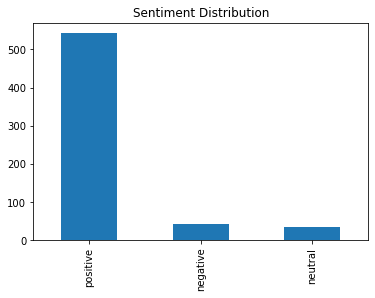

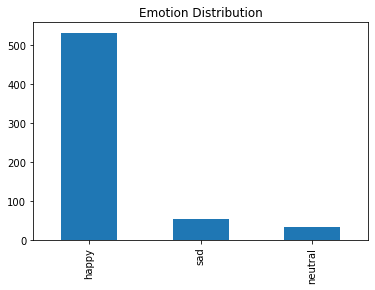

In [12]:
# View sentiment distribution
data["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution")
plt.show()
data["emotion"].value_counts().plot(kind="bar", title="Emotion Distribution")
plt.show()

In [13]:
# drop title and post_body
data = data.drop(columns=["title", "post_body"])

# count unique values for source, make, model, sentiment, emotion, urgency
print(
    data["source"].nunique(),
    data["make"].nunique(),
    data["model"].nunique(),
    data["sentiment"].nunique(),
    data["emotion"].nunique(),
    data["urgency"].nunique(),
)

categorical_columns = ["source", "make", "model", "sentiment", "emotion", "urgency"]
data = pd.get_dummies(data, columns=categorical_columns)

# data.dtypes

2 26 168 3 3 2


In [21]:
# View size of data
data.tail()

,price,odometer,year,imageCount,flagged,listed_price,post_length,emoji_ratio,contains_vin,cashonly_mention,...,model_Yukon XL,model_i5,sentiment_negative,sentiment_neutral,sentiment_positive,emotion_happy,emotion_neutral,emotion_sad,urgency_not urgent,urgency_urgent
1057,10999,154904.0,2013,24.0,False,1497.0,2280,0.018421,1,0,...,0,0,0,0,1,1,0,0,0,1
1058,29997,85423.0,2019,24.0,False,11328.0,1463,0.000000,0,0,...,0,0,0,0,1,1,0,0,0,1
1059,8500,104187.0,2018,10.0,False,-3233.0,224,0.000000,0,0,...,0,0,0,0,1,1,0,0,1,0
1060,9999,122608.0,2017,23.0,False,-33176.0,1968,0.021341,1,0,...,0,0,0,0,1,1,0,0,0,1
1061,7995,118800.0,2016,20.0,False,-249.0,299,0.000000,0,0,...,0,0,0,0,1,1,0,0,1,0


# Step 2: Exploratory Data Analysis (EDA)


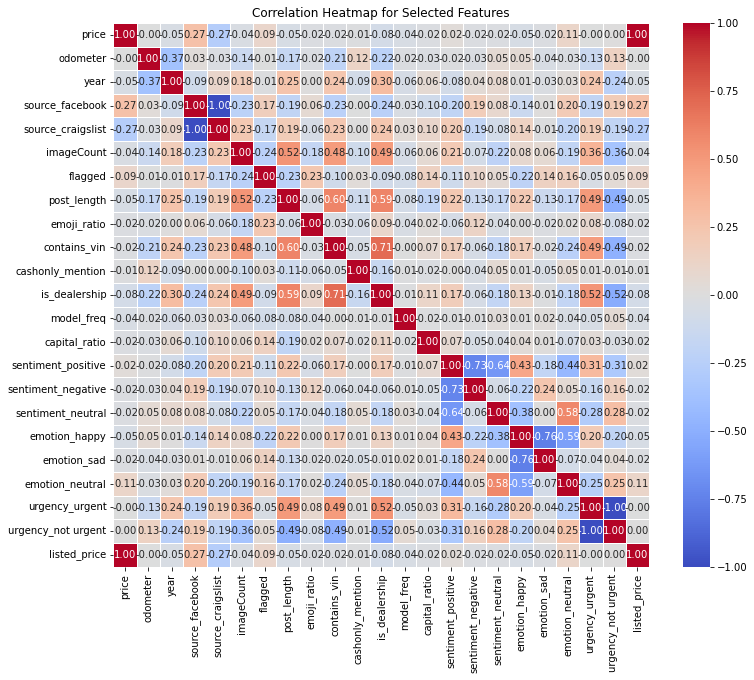

In [23]:
selected_columns = [
    "price",
    "odometer",
    "year",
    "source_facebook",
    "source_craigslist",
    "imageCount",
    "flagged",
    "post_length",
    "emoji_ratio",
    "contains_vin",
    "cashonly_mention",
    "is_dealership",
    "model_freq",
    "capital_ratio",
    "sentiment_positive",
    "sentiment_negative",
    "sentiment_neutral",
    "emotion_happy",
    "emotion_sad",
    "emotion_neutral",
    "urgency_urgent",
    "urgency_not urgent",
    "listed_price",
]

# Filter the DataFrame to include only the selected columns
filtered_data = data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = filtered_data.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # You can adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap for Selected Features")
plt.show()

In [15]:
# sns.boxplot(x='flagged', y='price_deviation', data=data)
# plt.title('Price Deviation by Fraud Label')
# plt.show()

# Step 3: Model Selection


In [16]:
# Split data into features and target
X = data.drop("flagged", axis=1)
y = data["flagged"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [24]:
# Initialize and train a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

# Step 4: Model Training and Validation


In [25]:
# Predict on test data
y_pred = model.predict(X_test)

In [26]:
# Hyperparameter tuning (example using GridSearch)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5
)
CV_rfc.fit(X_train, y_train)
print("Best parameters:", CV_rfc.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 50}


# Step 5: Evaluation


In [27]:
# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.92      0.81       113
        True       0.79      0.47      0.59        73

    accuracy                           0.74       186
   macro avg       0.76      0.69      0.70       186
weighted avg       0.75      0.74      0.72       186

Confusion Matrix:
 [[104   9]
 [ 39  34]]
Accuracy Score: 0.7419354838709677
